<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Plotting-Configs" data-toc-modified-id="Plotting-Configs-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Plotting Configs</a></span></li></ul></li><li><span><a href="#Appendix-B" data-toc-modified-id="Appendix-B-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Appendix B</a></span><ul class="toc-item"><li><span><a href="#Figure-20:-CRLBs-vs.-Sampling" data-toc-modified-id="Figure-20:-CRLBs-vs.-Sampling-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Figure 20: CRLBs vs. Sampling</a></span></li></ul></li><li><span><a href="#Appendix-C" data-toc-modified-id="Appendix-C-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Appendix C</a></span><ul class="toc-item"><li><span><a href="#Figure-21:-DESI-CRLBs" data-toc-modified-id="Figure-21:-DESI-CRLBs-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Figure 21: DESI CRLBs</a></span></li></ul></li></ul></div>

## Imports

In [1]:
import pandas as pd
import numpy as np

from chemicalc import instruments as inst
from chemicalc import reference_spectra as ref
from chemicalc import s2n
from chemicalc.crlb import init_crlb_df, calc_crlb, sort_crlb
from chemicalc.plot import plot_crlb

from astropy.io import fits

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import StrMethodFormatter
from matplotlib.lines import Line2D
%matplotlib inline

## Plotting Configs

In [2]:
output_dir = './figures/'

mpl.rc('axes', grid=True, lw=2)
mpl.rc('ytick', direction='in', labelsize=10)
mpl.rc('ytick.major', size=5, width=1)
mpl.rc('xtick', direction='in', labelsize=10)
mpl.rc('xtick.major', size=5, width=1)
mpl.rc('ytick', direction='in', labelsize=10)
mpl.rc('ytick.major', size=5, width=1)
mpl.rc('grid', alpha=0.75, lw=1)
mpl.rc('legend', edgecolor='k', framealpha=1, fancybox=False)
mpl.rc('figure', dpi=300)

# Appendix C
## Figure 20: CRLBs vs. Wavelength Sampling / Correlation

In [3]:
# Initialize Preset Instrument
allInst = inst.AllInstruments()
d1200g_1 = inst.InstConfig(f'DEIMOS 1200G (1)', res=6500, samp=1, start=6500, end=9000)
d1200g_2 = inst.InstConfig(f'DEIMOS 1200G (2)', res=6500, samp=2, start=6500, end=9000)
d1200g_3 = inst.InstConfig(f'DEIMOS 1200G (3)', res=6500, samp=3, start=6500, end=9000)
d1200g_4 = inst.InstConfig(f'DEIMOS 1200G (4)', res=6500, samp=4, start=6500, end=9000)


# Initialize Reference Spectra
RGB = ref.ReferenceSpectra(reference='RGB_m1.5')

# Convolve Spectra
RGB.convolve(d1200g_1)
RGB.convolve(d1200g_2)
RGB.convolve(d1200g_3)
RGB.convolve(d1200g_4)

# Calculate Gradient Spectra
RGB.calc_gradient(d1200g_1)
RGB.calc_gradient(d1200g_2)
RGB.calc_gradient(d1200g_3)
RGB.calc_gradient(d1200g_4)

# Set S/N
d1200G_snr_query = s2n.Sig2NoiseDEIMOS(grating='1200G', exptime=3600, mag=19.5, magtype='Vega',
                                       band='Buser_V.dat', template='K0V_pickles_32.fits',
                                       cwave='7000', slitwidth='0.75', binning='1x1',
                                       airmass=1.1, seeing=0.75, redshift=0)
d1200g_1.set_snr(d1200G_snr_query, fill_value='extrapolate')
d1200g_2.set_snr(d1200G_snr_query, fill_value='extrapolate')
d1200g_3.set_snr(d1200G_snr_query, fill_value='extrapolate')
d1200g_4.set_snr(d1200G_snr_query, fill_value='extrapolate')

# Initialize CRLB Data Frames
CRLB_samp = init_crlb_df(RGB)
CRLB_corr = init_crlb_df(RGB)

# Calculate CRLB
CRLB_samp['4 pix/FWHM'] = calc_crlb(RGB, d1200g_4)
CRLB_samp['3 pix/FWHM'] = calc_crlb(RGB, d1200g_3)
CRLB_samp['2 pix/FWHM'] = calc_crlb(RGB, d1200g_2)
CRLB_samp['1 pix/FWHM'] = calc_crlb(RGB, d1200g_1)
CRLB_corr['3 pix/FWHM (10%)'] = calc_crlb(RGB, d1200g_3, pixel_corr=[0.10])
CRLB_corr['3 pix/FWHM (30%)'] = calc_crlb(RGB, d1200g_3, pixel_corr=[0.30])
CRLB_corr['3 pix/FWHM (50%)'] = calc_crlb(RGB, d1200g_3, pixel_corr=[0.50])
CRLB_corr['3 pix/FWHM (99%)'] = calc_crlb(RGB, d1200g_3, pixel_corr=[0.99])

# Sort CRLBs & Pretty Up Indices
CRLB_samp = sort_crlb(CRLB_samp, cutoff=0.3, fancy_labels=True)
CRLB_corr = sort_crlb(CRLB_corr, cutoff=0.3, fancy_labels=True)

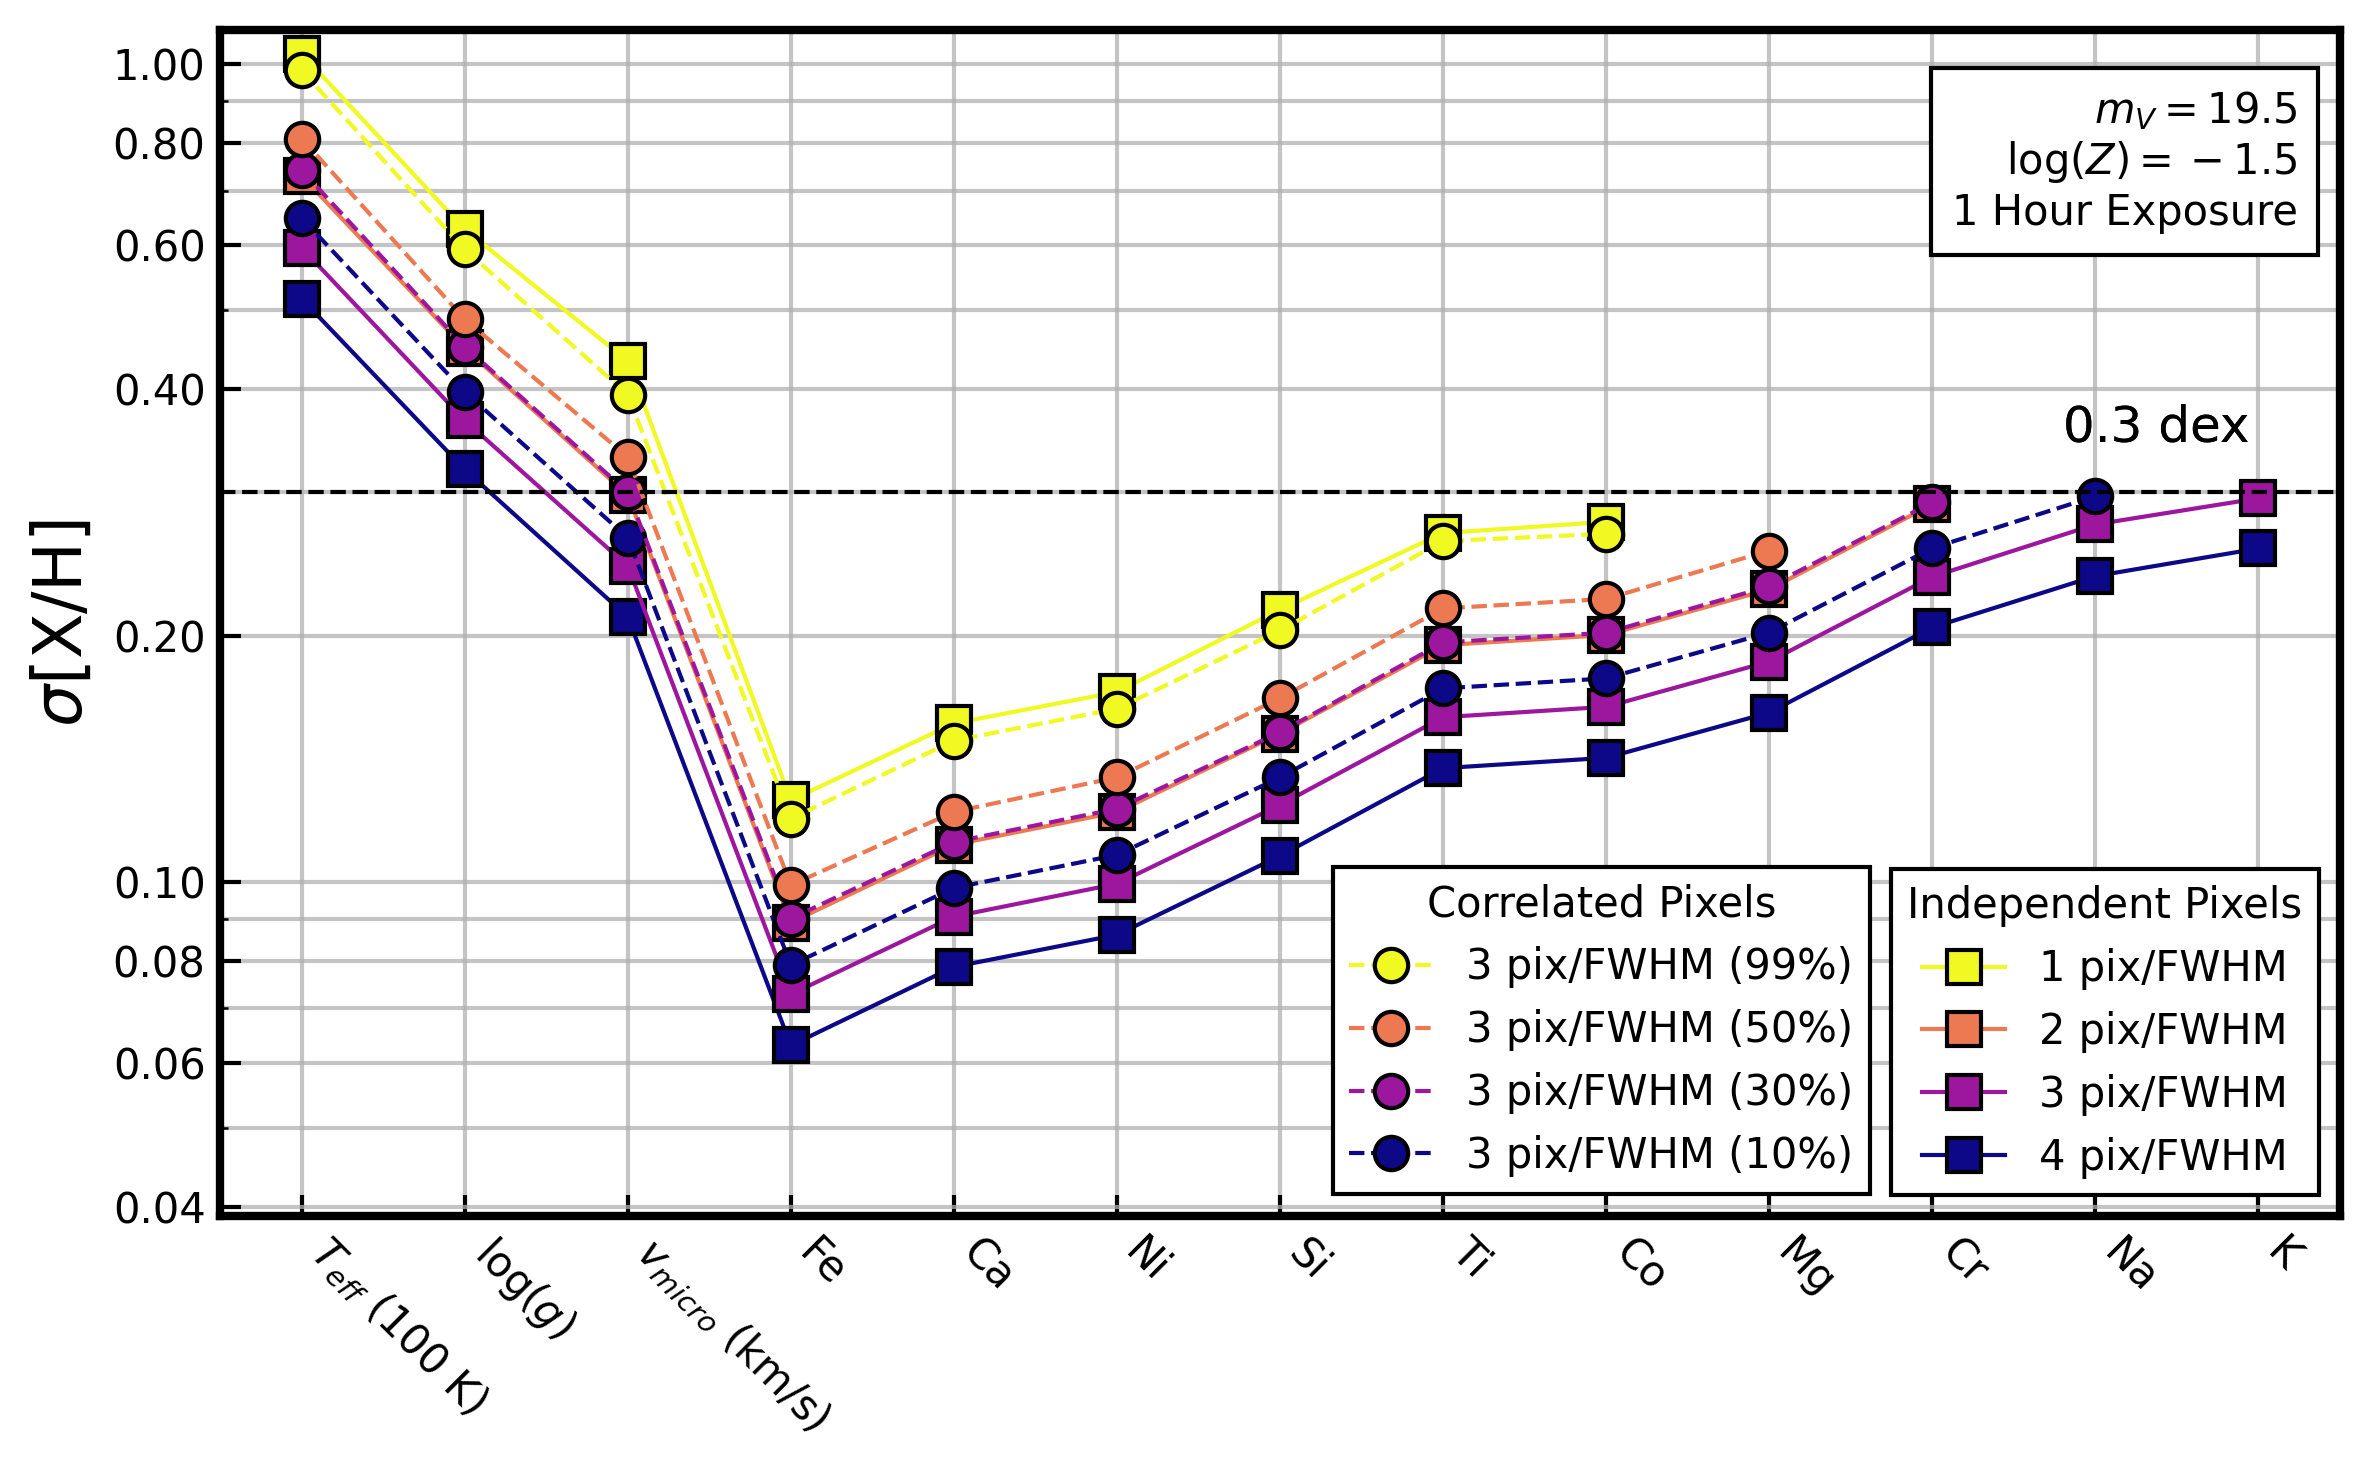

In [4]:
# Adapted from chemicalc.plot.overplot() for the specific needs of this figure
# Args
crlb_list = [CRLB_samp, CRLB_corr]
names = ['Independent Pixels', 'Correlated Pixels']
cutoff = 0.3
labels = ['$m_V=19.5$\n$\log(Z)=-1.5$\n1 Hour Exposure']
label_loc = (0.98, 0.95)
panel_height = 5
panel_width = 8
cutoff_label_xoffset = 2.2
cutoff_label_yoffset = 0.045
ylim = (0.039, 1.1)
yticks = [0.04, 0.06, 0.08, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
legend_ncol = 1
legend_loc = "lower right"
reverse_legend = True
legend2_ncol = 1
legend2_loc = (0.515, 0.312)
reverse_legend2 = True
color_palette = "plasma"

# Plotting
lead_crlb = np.argmax([len(crlb.index) for crlb in crlb_list])
all_labs = crlb_list[lead_crlb].index
nlabs = all_labs.shape[0]
# Initialize Figure
fig = plt.figure(figsize=(panel_width, panel_height))
gs = GridSpec(1, 1)
gs.update(hspace=0.0)
ax = plt.subplot(gs[0, 0])
c = plt.cm.get_cmap(color_palette, np.max([crlb.shape[1] for crlb in crlb_list]))
lines = ["-", "--", ":", "-."]
markers = ["s", "o"]
custom_lines = []
leg2_names = []
# Iterate through DataFrames
for i, crlb in enumerate(crlb_list):
    labs = crlb.index
    cols = crlb_list[i].columns
    # Iterate through CRLBs w/in set
    for j, col in enumerate(cols):
        if i == 0:
            label = col
        else:
            label = "_nolegend_"
            custom_lines.append(
                Line2D(
                    [0], [0], color=c(j), lw=1, ls=lines[i], marker=markers[i], markersize=8, markeredgewidth=1, markeredgecolor="k",
                )
            )
            leg2_names.append(col)
        mask = pd.notnull(crlb[col].loc[labs].values)
        plt.plot(
            crlb[col].loc[labs].index[mask],
            crlb[col].loc[labs].values[mask],
            marker=markers[i],
            markersize=8,
            markeredgewidth=1,
            linestyle=lines[i],
            linewidth=1,
            color=c(j),
            markeredgecolor="k",
            label=label,
        )
# Plot cutoff line
if cutoff:
    ax.axhline(cutoff, ls="--", lw=1, c="k")
    plt.text(
        s=f"{cutoff:01.1f} dex",
        x=nlabs - cutoff_label_xoffset,
        y=cutoff + cutoff_label_yoffset,
        fontsize=12,
    )
plt.text(
    s="0.3 dex",
    x=nlabs - cutoff_label_xoffset,
    y=cutoff + cutoff_label_yoffset,
    fontsize=12,
)
# Axes
ax.set_ylabel(r"$\sigma$[X/H]", size=16)
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))
ax.set_xlim(-0.5, nlabs - 0.5)
ax.set_ylim(ylim)
ax.set_yscale("log")
plt.grid(True, "both", "both")
ax.tick_params(axis="x", which="major", rotation=-45)
for label in ax.get_xticklabels():
    label.set_horizontalalignment("left")
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))
# Add Label
if labels is not None:
    for i, label in enumerate(labels):
        plt.text(
            label_loc[0],
            label_loc[1],
            s=labels[i],
            fontsize=10,
            horizontalalignment="right",
            verticalalignment="top",
            transform=ax.transAxes,
            bbox=dict(fc="white", ec="black", lw=1, pad=5.0),
        )
# Legend
if reverse_legend2:
    custom_lines = custom_lines[::-1]
    leg2_names = leg2_names[::-1]
leg2 = fig.axes[0].legend(
    custom_lines,
    leg2_names,
    fontsize=10,
    ncol=legend2_ncol,
    bbox_to_anchor=legend2_loc,
    edgecolor="k",
    title=names[1]
)
plt.legend(fontsize=10, ncol=legend_ncol, loc=legend_loc, title=names[0])
if reverse_legend:
    leg_handles, leg_labels = fig.axes[0].get_legend_handles_labels()
    fig.axes[0].legend(
        leg_handles[::-1],
        leg_labels[::-1],
        fontsize=10,
        ncol=legend_ncol,
        loc=legend_loc,
        title=names[0]
    )
fig.axes[0].add_artist(leg2)
if yticks is not None:
    fig.axes[0].set_yticks(yticks)
plt.tight_layout()

plt.savefig(output_dir+'crlb_sampling.png')

# Appendix D
## Figure 21: Comparison to Literature (Xiang+ 2019)

In [5]:
# Calculate LAMOST CRLB
# Initialize Preset Instrument
lamost = inst.AllInst.get_spectrograph('LAMOST')

# Initialize Reference Spectra
KGiant = ref.ReferenceSpectra(reference='KGiant', alpha_included=False)

# Convolve Reference Spectra to Instrument Resolution
KGiant.convolve(lamost)

# Calculate Gradient Spectra
KGiant.calc_gradient(lamost)
KGiant.zero_gradients(lamost, ['Li', 'Sc', 'V', 'Zn', 'Y', 'Eu'])  # Intentionally ignored by Xiang+ 2019
KGiant.zero_gradients(lamost, ['Nd', 'Ce', 'Zr', 'La', 'Pr', 'Sm', 'K', 'Sr', 'Mo'])  # Not included in Xiang+ 2019 training sets

# Initialize CRLB Data Frames
CRLB = init_crlb_df(KGiant)

# Query S/N & Calculate CRLBs
star1_file = './etc_files/snrcurve_SNR50-star1.fits'
star2_file = './etc_files/snrcurve_SNR50-star2.fits'
with fits.open(star1_file) as hdul:
    wave1 = hdul[0].data
    snr1 = hdul[1].data
with fits.open(star2_file) as hdul:
    wave2 = hdul[0].data
    snr2 = hdul[1].data
lamost_snr = np.vstack([wave1, np.mean([snr1,snr2], axis=0)])
lamost.set_snr(lamost_snr, fill_value='extrapolate')
CRLB[r'LAMOST'] = calc_crlb(KGiant, lamost)
# Transform to precision of [X/Fe]
CRLB.loc[set(CRLB.index) ^ set(list(CRLB.index[:3])+['Fe'])] = np.sqrt(CRLB.loc[set(CRLB.index) ^ set(list(CRLB.index[:3])+['Fe'])]**2 + CRLB.loc['Fe']**2)
    
# Sort CRLBs & Pretty Up Indices
CRLB = sort_crlb(CRLB, cutoff=0.3, fancy_labels=True)

/Users/nathansandford/github_repos/Chem-I-Calc/chemicalc/crlb.py:82: RuntimeWarning: divide by zero encountered in power
  flux_var = instrument.snr ** (-2)


In [6]:
# Load Xiang+ 2019 Results
xiang_19_file = './DDPayne_LAMOST-DR5_recommend.fits' # Download from: http://paperdata.china-vo.org/vac/dr5/DDPayne_LAMOST-DR5_recommend.fits
with fits.open(xiang_19_file) as hdul:
    data = hdul[1].data[(hdul[1].data['SNR_G   '] < 60) & (hdul[1].data['SNR_G   '] > 40) & \
                        (hdul[1].data['QFLAG_CHI2'] == 'good') & \
                        (hdul[1].data['FEH     '] > -0.1) & (hdul[1].data['FEH     '] < 0.1) & \
                        (hdul[1].data['ALPHA_FE'] > -0.1) & (hdul[1].data['ALPHA_FE'] < 0.1) & \
                        (hdul[1].data['TEFF'] > 4600) & (hdul[1].data['TEFF'] < 5000) & \
                        (hdul[1].data['LOGG'] > 2.3) & (hdul[1].data['LOGG'] < 2.7)]

# Read precision
CRLB['Xiang+ (2019)'] = np.nan
# From GALAH trained model
CRLB['Xiang+ (2019)'].loc['$T_{eff}$ (100 K)'] = data['TEFF_ERR'][(data['TEFF_FLAG'] == 1)].mean() / 100
CRLB['Xiang+ (2019)'].loc['Na'] = data['NA_FE_ERR '][data['NA_FE_FLAG'] == 1].mean()
CRLB['Xiang+ (2019)'].loc['Mg'] = data['MG_FE_ERR '][data['MG_FE_FLAG'] == 1].mean()
CRLB['Xiang+ (2019)'].loc['Al'] = data['AL_FE_ERR '][data['AL_FE_FLAG'] == 1].mean()
CRLB['Xiang+ (2019)'].loc['Si'] = data['SI_FE_ERR '][data['SI_FE_FLAG'] == 1].mean()
CRLB['Xiang+ (2019)'].loc['Ti'] = data['TI_FE_ERR '][data['TI_FE_FLAG'] == 1].mean()
CRLB['Xiang+ (2019)'].loc['Cr'] = data['CR_FE_ERR '][data['CR_FE_FLAG'] == 1].mean()
CRLB['Xiang+ (2019)'].loc['Mn'] = data['MN_FE_ERR '][data['MN_FE_FLAG'] == 1].mean()
CRLB['Xiang+ (2019)'].loc['Co'] = data['CO_FE_ERR '][data['CO_FE_FLAG'] == 1].mean()
CRLB['Xiang+ (2019)'].loc['Ba'] = data['BA_FE_ERR '][data['BA_FE_FLAG'] == 1].mean()
# From APOGEE trained model
CRLB['Xiang+ (2019)'].loc['$\log(g)$'] = data['LOGG_ERR'][(data['LOGG_FLAG'] == 1)].mean()
CRLB['Xiang+ (2019)'].loc['$v_{micro}$ (km/s)'] = data['VMIC_ERR'][(data['VMIC_FLAG'] == 1)].mean()
CRLB['Xiang+ (2019)'].loc['C'] = data['C_FE_ERR '][data['C_FE_FLAG'] == 1].mean()
CRLB['Xiang+ (2019)'].loc['N'] = data['N_FE_ERR '][data['N_FE_FLAG'] == 1].mean()
CRLB['Xiang+ (2019)'].loc['O'] = data['O_FE_ERR '][data['O_FE_FLAG'] == 1].mean()
CRLB['Xiang+ (2019)'].loc['Ca'] = data['Ca_FE_ERR '][data['Ca_FE_FLAG'] == 1].mean()
CRLB['Xiang+ (2019)'].loc['Fe'] = data['FEH_ERR '][(data['FEH_FLAG'] == 1)].mean()
CRLB['Xiang+ (2019)'].loc['Ni'] = data['NI_FE_ERR '][data['NI_FE_FLAG'] == 1].mean()
CRLB['Xiang+ (2019)'].loc['Cu'] = data['CU_FE_ERR '][data['CU_FE_FLAG'] == 1].mean()

# Calculate Quartiles
xiang_quartiles_nosyst = pd.DataFrame(index=CRLB.index)
xiang_quartiles_nosyst['upper'] = np.nan
xiang_quartiles_nosyst['lower'] = np.nan
xiang_quartiles_nosyst['upper'].loc['$T_{eff}$ (100 K)'], xiang_quartiles_nosyst['lower'].loc['$T_{eff}$ (100 K)'] = np.quantile(data['TEFF_ERR'][(data['TEFF_FLAG'] == 1)], [0.25,0.75]) / 100
xiang_quartiles_nosyst['upper'].loc['$\log(g)$'], xiang_quartiles_nosyst['lower'].loc['$\log(g)$'] = np.quantile(data['LOGG_ERR'][(data['LOGG_FLAG'] == 1)], [0.25,0.75])
xiang_quartiles_nosyst['upper'].loc['$v_{micro}$ (km/s)'], xiang_quartiles_nosyst['lower'].loc['$v_{micro}$ (km/s)'] = np.quantile(data['VMIC_ERR'][(data['VMIC_FLAG'] == 1)], [0.25,0.75])
xiang_quartiles_nosyst['upper'].loc['Na'], xiang_quartiles_nosyst['lower'].loc['Na'] = np.quantile(data['NA_FE_ERR '][data['NA_FE_FLAG'] == 1], [0.25,0.75])
xiang_quartiles_nosyst['upper'].loc['Mg'], xiang_quartiles_nosyst['lower'].loc['Mg'] = np.quantile(data['MG_FE_ERR '][data['MG_FE_FLAG'] == 1], [0.25,0.75])
xiang_quartiles_nosyst['upper'].loc['Al'], xiang_quartiles_nosyst['lower'].loc['Al'] = np.quantile(data['AL_FE_ERR '][data['AL_FE_FLAG'] == 1], [0.25,0.75])
xiang_quartiles_nosyst['upper'].loc['Si'], xiang_quartiles_nosyst['lower'].loc['Si'] = np.quantile(data['SI_FE_ERR '][data['SI_FE_FLAG'] == 1], [0.25,0.75])
xiang_quartiles_nosyst['upper'].loc['Ti'], xiang_quartiles_nosyst['lower'].loc['Ti'] = np.quantile(data['TI_FE_ERR '][data['TI_FE_FLAG'] == 1], [0.25,0.75])
xiang_quartiles_nosyst['upper'].loc['Cr'], xiang_quartiles_nosyst['lower'].loc['Cr'] = np.quantile(data['CR_FE_ERR '][data['CR_FE_FLAG'] == 1], [0.25,0.75])
xiang_quartiles_nosyst['upper'].loc['Mn'], xiang_quartiles_nosyst['lower'].loc['Mn'] = np.quantile(data['MN_FE_ERR '][data['MN_FE_FLAG'] == 1], [0.25,0.75])
xiang_quartiles_nosyst['upper'].loc['Co'], xiang_quartiles_nosyst['lower'].loc['Co'] = np.quantile(data['CO_FE_ERR '][data['CO_FE_FLAG'] == 1], [0.25,0.75])
xiang_quartiles_nosyst['upper'].loc['Ba'], xiang_quartiles_nosyst['lower'].loc['Ba'] = np.quantile(data['BA_FE_ERR '][data['BA_FE_FLAG'] == 1], [0.25,0.75])
xiang_quartiles_nosyst['upper'].loc['C'], xiang_quartiles_nosyst['lower'].loc['C'] = np.quantile(data['C_FE_ERR '][data['C_FE_FLAG'] == 1], [0.25,0.75])
xiang_quartiles_nosyst['upper'].loc['N'], xiang_quartiles_nosyst['lower'].loc['N'] = np.quantile(data['N_FE_ERR '][data['N_FE_FLAG'] == 1], [0.25,0.75])
xiang_quartiles_nosyst['upper'].loc['O'], xiang_quartiles_nosyst['lower'].loc['O'] = np.quantile(data['O_FE_ERR '][data['O_FE_FLAG'] == 1], [0.25,0.75])
xiang_quartiles_nosyst['upper'].loc['Ca'], xiang_quartiles_nosyst['lower'].loc['Ca'] = np.quantile(data['Ca_FE_ERR '][data['Ca_FE_FLAG'] == 1], [0.25,0.75])
xiang_quartiles_nosyst['upper'].loc['Fe'], xiang_quartiles_nosyst['lower'].loc['Fe'] = np.quantile(data['FEH_ERR '][(data['FEH_FLAG'] == 1)], [0.25,0.75])
xiang_quartiles_nosyst['upper'].loc['Ni'], xiang_quartiles_nosyst['lower'].loc['Ni'] = np.quantile(data['NI_FE_ERR '][data['NI_FE_FLAG'] == 1], [0.25,0.75])
xiang_quartiles_nosyst['upper'].loc['Cu'], xiang_quartiles_nosyst['lower'].loc['Cu'] = np.quantile(data['CU_FE_ERR '][data['CU_FE_FLAG'] == 1], [0.25,0.75])

/Users/nathansandford/opt/anaconda3/envs/chemicalc_test/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Users/nathansandford/opt/anaconda3/envs/chemicalc_test/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


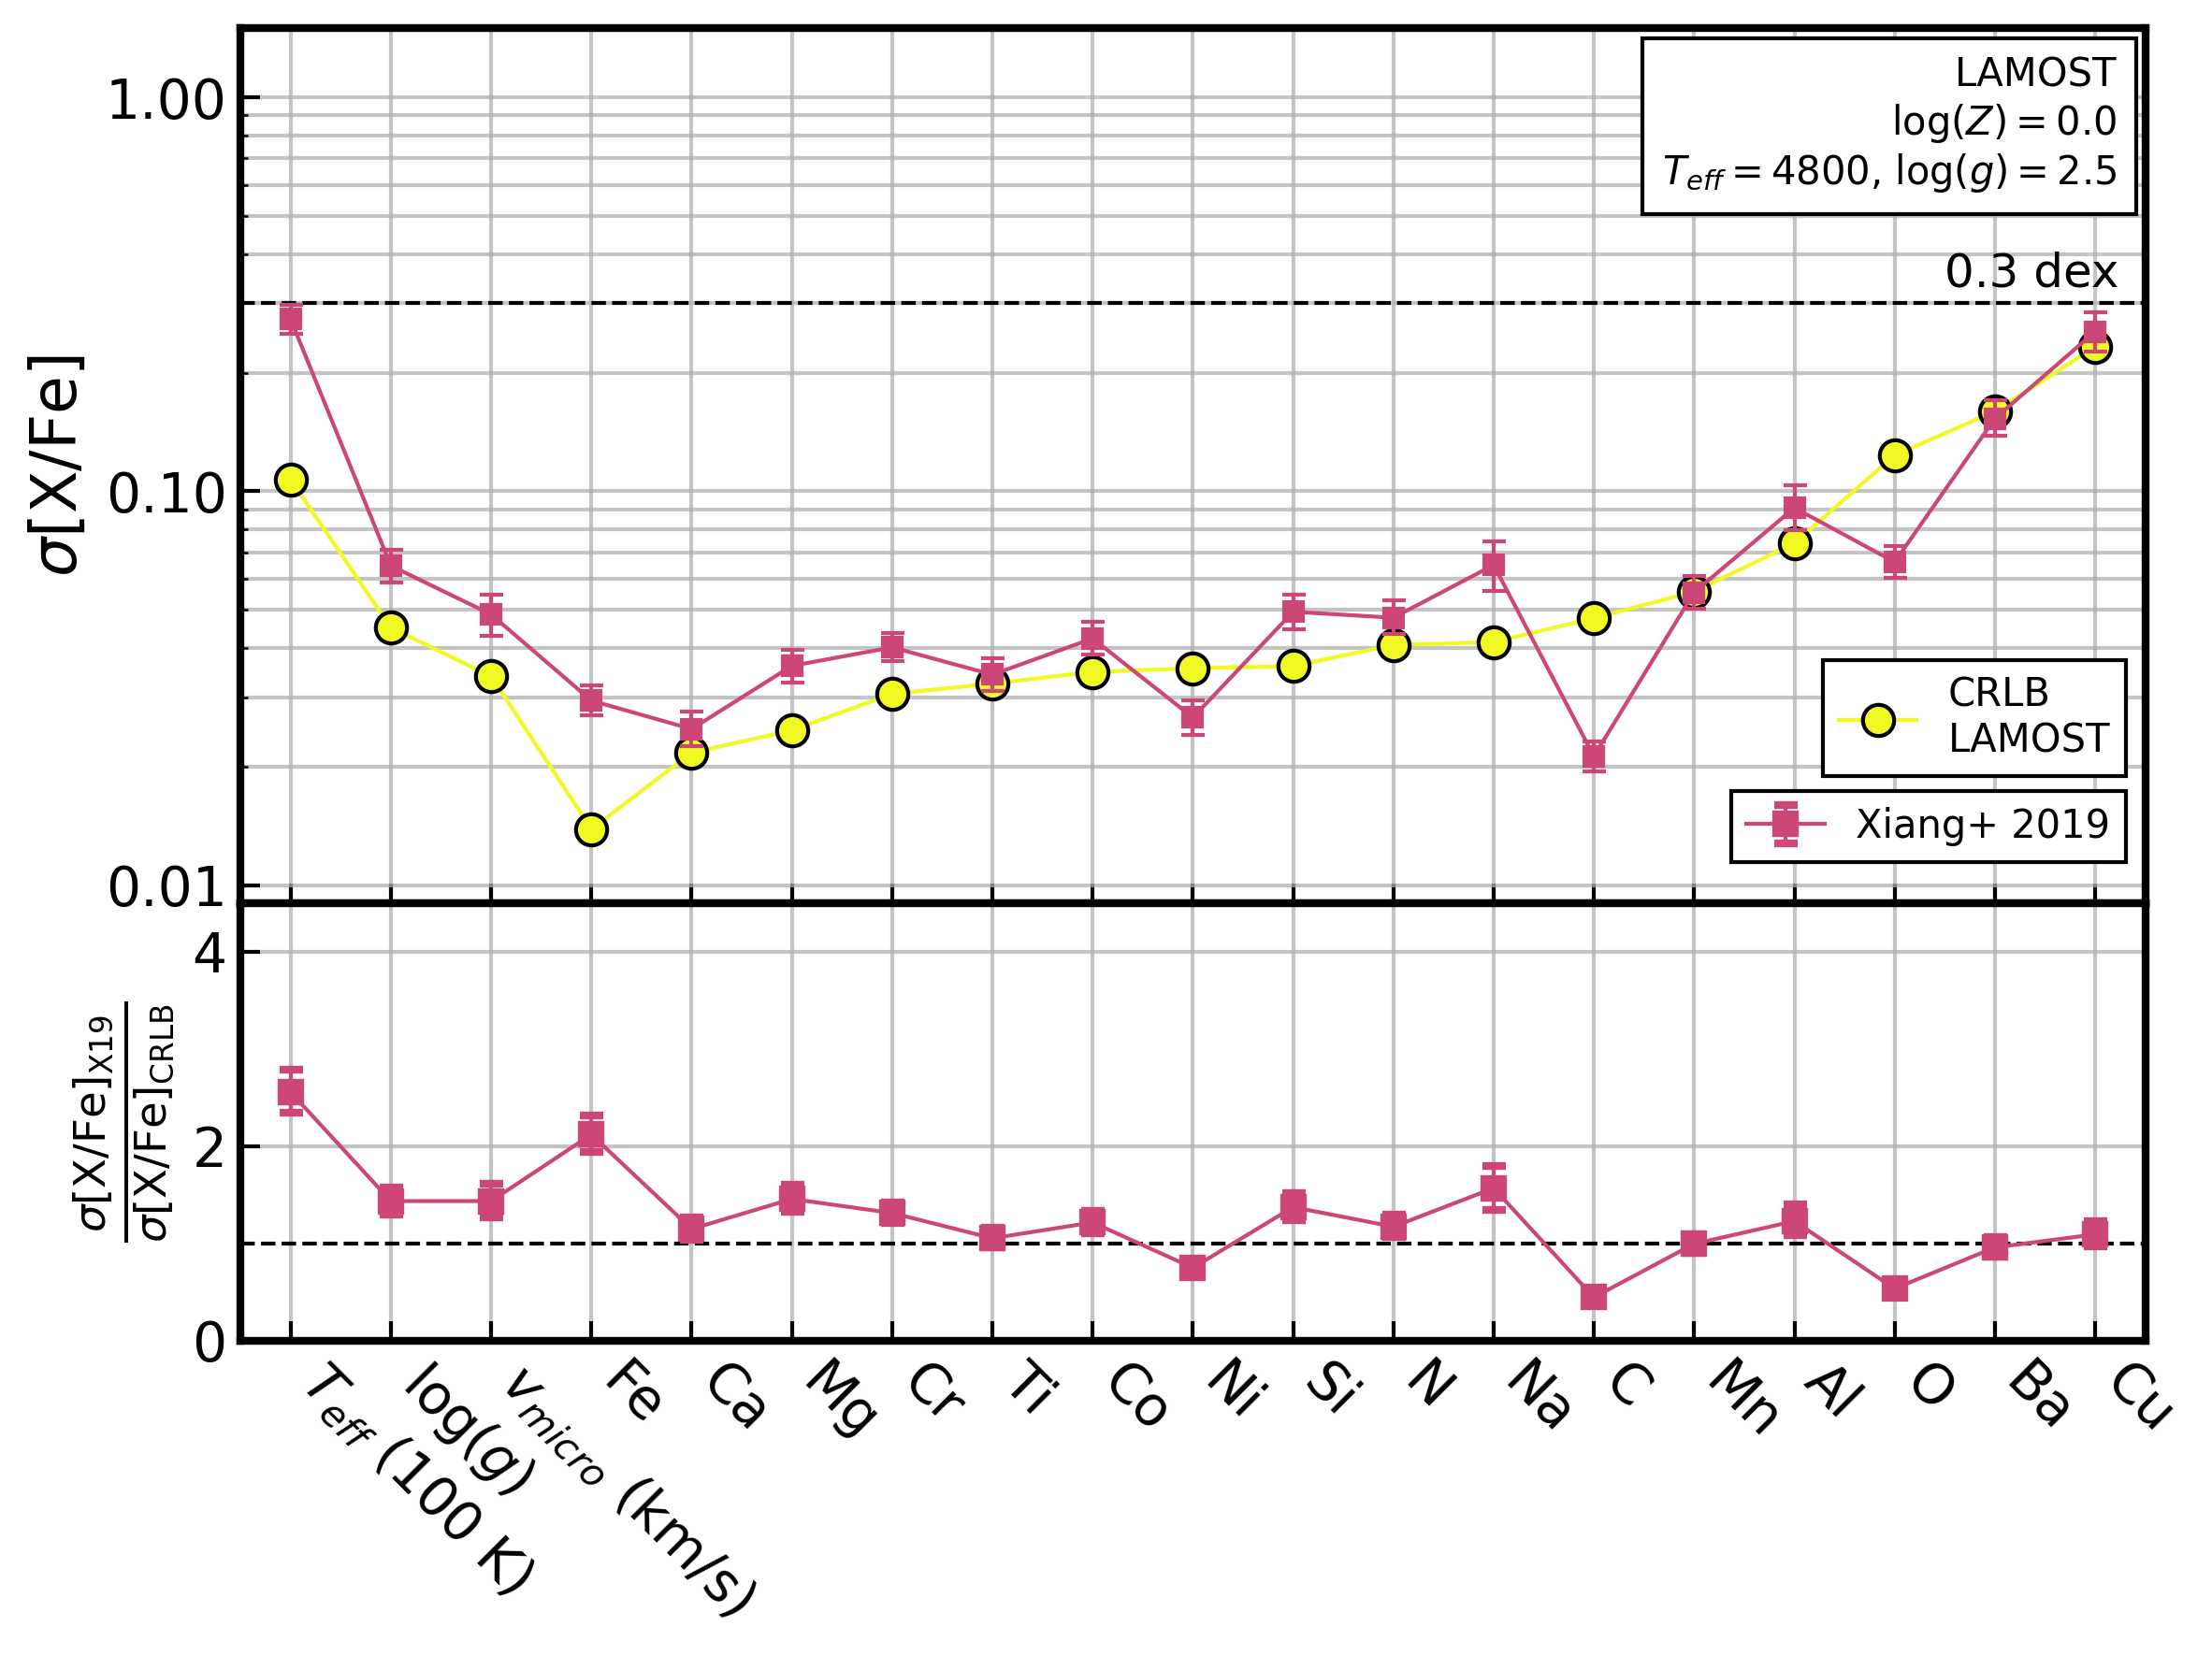

In [8]:
color_palette = 'plasma'
ylim = (0.009, 1.5)

crlb_col = 'LAMOST'
data_col1  = 'Xiang+ (2019)'
crlb = CRLB.loc[:, crlb_col]
data1 = CRLB.loc[:, data_col1]

# Initialize Figure
fig = plt.figure(figsize=(8, 6))
gs = GridSpec(2, 1, height_ratios=(2,1))
gs.update(hspace=0.0)
ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[1, 0], sharex=ax0)

labs = crlb.index
nlabs = len(labs)
c = plt.cm.get_cmap(color_palette, 3)

# Plot CRLBs and reported precision
mask = pd.notnull(crlb.loc[labs].values)
ax0.plot(crlb.loc[labs].index[mask],
         crlb.loc[labs].values[mask],
         marker='o', markersize=8, markeredgewidth=1,
         linestyle='-', linewidth=1,
         color=c(2), markeredgecolor='k',
         label='CRLB\nLAMOST',zorder=2)
ax0.errorbar(x=data1.index,
             y=data1.values,
             yerr=np.vstack([np.abs(xiang_quartiles_nosyst['lower']-data1), np.abs(xiang_quartiles_nosyst['upper']-data1)]),
             markersize=5, fmt='s-', mfc=c(1), linewidth=1, color=c(1),
             mec=c(1), mew=1, capsize=3, elinewidth=1, ecolor=c(1), zorder=10,)
ax0.axhline(0.3, ls='--', lw=1, c='k')
ax0.text(s='0.3 dex', x=16.5, y=0.33, fontsize=12)

# Plot Difference
ax1.plot(crlb.loc[labs].index[mask],
         crlb.loc[labs].values[mask],
         marker='o', markersize=0, markeredgewidth=0,
         linestyle='-', linewidth=0,
         color=c(2), markeredgecolor='k',
         label='Xiang+ (2019)')
err1 = ax1.errorbar(x=data1.index,
                    y=data1.values / crlb.values,
                    yerr=np.vstack([np.abs(xiang_quartiles_nosyst['lower']-data1), np.abs(xiang_quartiles_nosyst['upper']-data1)])/crlb.values,
                    markersize=5, fmt='s-', mfc=c(1), linewidth=1, color=c(1),
                    mec=c(1), mew=2, capsize=3, elinewidth=1, ecolor=c(1), zorder=10)
ax1.axhline(1.0, ls='--', lw=1, c='k')

# Axes
ax0.set_ylabel(r'$\sigma$[X/Fe]', size=16)
ax1.set_ylabel(r'$\frac{\sigma[\mathrm{X/Fe}]_{\mathrm{X19}}}{\sigma[\mathrm{X/Fe}]_{\mathrm{CRLB}}}$', size=16)
ax0.set_xlim(-0.5, nlabs - 0.5)
ax0.set_ylim(ylim)
ax1.set_ylim(0.0, 4.5)
ax0.set_yscale('log')
ax0.grid(True, 'both', 'both')
ax1.grid(True, 'both', 'both')
ax0.tick_params(axis='x', labelsize=0)
ax1.tick_params(axis='x', which='major', rotation=-45, labelsize=14)
ax0.tick_params(axis='y', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
for j, label in enumerate(ax1.get_xticklabels()):
    label.set_horizontalalignment('left')
ax0.yaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))

# Legends
ax0.legend(fontsize=12, ncol=1, loc='lower right', edgecolor='k')
plt.text(0.985, 0.968, s='LAMOST\n$\log(Z)=0.0$\n$T_{eff}=4800$, $\log(g)=2.5$', fontsize=10,
         horizontalalignment='right',
         verticalalignment='top',
         transform=ax0.transAxes,
         bbox=dict(facecolor='white', edgecolor='black', pad=5.0))
handles, labels = fig.axes[0].get_legend_handles_labels()
fig.axes[0].legend(handles[:], labels[:], fontsize=10,
                   ncol=1, bbox_to_anchor=(0.805, 0.234), edgecolor='k')
custom_lines = [Line2D([0], [0], color='k', marker='o', linestyle='None', ms=5)]
leg2 = fig.axes[0].legend([err1], ['Xiang+ 2019'],
                          fontsize=10,
                          bbox_to_anchor=(1.0, 0.025),
                          loc='lower right', edgecolor='k')
fig.axes[0].add_artist(leg2)
handles, labels = fig.axes[0].get_legend_handles_labels()
fig.axes[0].legend(handles, labels, fontsize=10,
                   ncol=1, bbox_to_anchor=(1.0, 0.3), edgecolor='k')

plt.tight_layout()
fig.savefig(output_dir+'crlb_lit_lamost.png')
plt.show()


# Appendix E

## Figure 22: CRLBs vs. HMC Sampling

In [9]:
# Labels to keep at each S/N
snr_labels = {200: ['Teff', 'logg', 'v_micro', 'Fe', 'Ca', 'Ni', 'Si', 'Ti', 'Co', 'Mg'],
              100: ['Teff', 'logg', 'v_micro', 'Fe', 'Ca', 'Ni', 'Si', 'Ti', 'Co', 'Mg'],
              50: ['Teff', 'logg', 'v_micro', 'Fe', 'Ca', 'Ni', 'Si', 'Ti', 'Co', 'Mg'],
              30: ['Teff', 'logg', 'v_micro', 'Fe', 'Ca', 'Ni', 'Si', 'Ti', 'Co', 'Mg'],
              20: ['Teff', 'logg', 'v_micro', 'Fe', 'Ca', 'Ni', 'Si', 'Ti'],
              15: ['Teff', 'logg', 'v_micro', 'Fe', 'Ca', 'Ni'],
              10: ['Teff', 'logg', 'v_micro', 'Fe', 'Ca'],
              5: ['Teff', 'logg', 'v_micro', 'Fe', 'Ca']}

# Initialize Preset Instrument
d1200g = inst.AllInst.get_spectrograph('DEIMOS 1200G')

# Initialize Reference Spectra
RGB = ref.ReferenceSpectra(reference='RGB_m1.5')

# Load NN Spectra
tmp = np.load('NN_spec.npz')
RGB.wavelength[d1200g.name] = tmp['wavelength']
RGB.spectra[d1200g.name] = tmp['spectra']
# Adjust ReferenceSpectra object b/c NN_spec was generated before 'alpha' was included as a label.
RGB.labels.drop(['alpha'], axis=0, inplace=True)
RGB.labels.drop(['aaaah', 'aaaai'], axis=1, inplace=True)
RGB.nlabels -= 1
RGB.nspectra = RGB.spectra[d1200g.name].shape[0]

# Initialize CRLB Data Frames
CRLB_NN = init_crlb_df(RGB)
CRLB_hmc = init_crlb_df(RGB)

# Define Prior
priors = {'Teff': 100, 'logg': 0.15, 'v_micro': 0.25}

# Calculate CRLBs for all S/N
for snr, labels_to_keep in snr_labels.items():
    # Calculate Gradient Spectra
    RGB.calc_gradient(d1200g)
    RGB.zero_gradients(d1200g, set(RGB.labels.index)^set(labels_to_keep))
    # Set S/N
    d1200g.set_snr(snr, fill_value='extrapolate')
    # Calculate CRLBs
    CRLB_NN[f'{snr}'] = calc_crlb(RGB, d1200g, priors=priors)
    # Load Precision from Sampling
    samples = pd.read_hdf(f'./hmc_samples/R6500p_snr{snr:03d}_samples.h5')
    CRLB_hmc[f'{snr}'] = samples.std()
    CRLB_hmc[f'{snr}'].loc['Teff'] /= 100

# Sort CRLBs & Pretty Up Indices
CRLB_NN = sort_crlb(CRLB_NN, cutoff=0.3, fancy_labels=True)
CRLB_hmc = sort_crlb(CRLB_hmc, cutoff=0.3, fancy_labels=True)

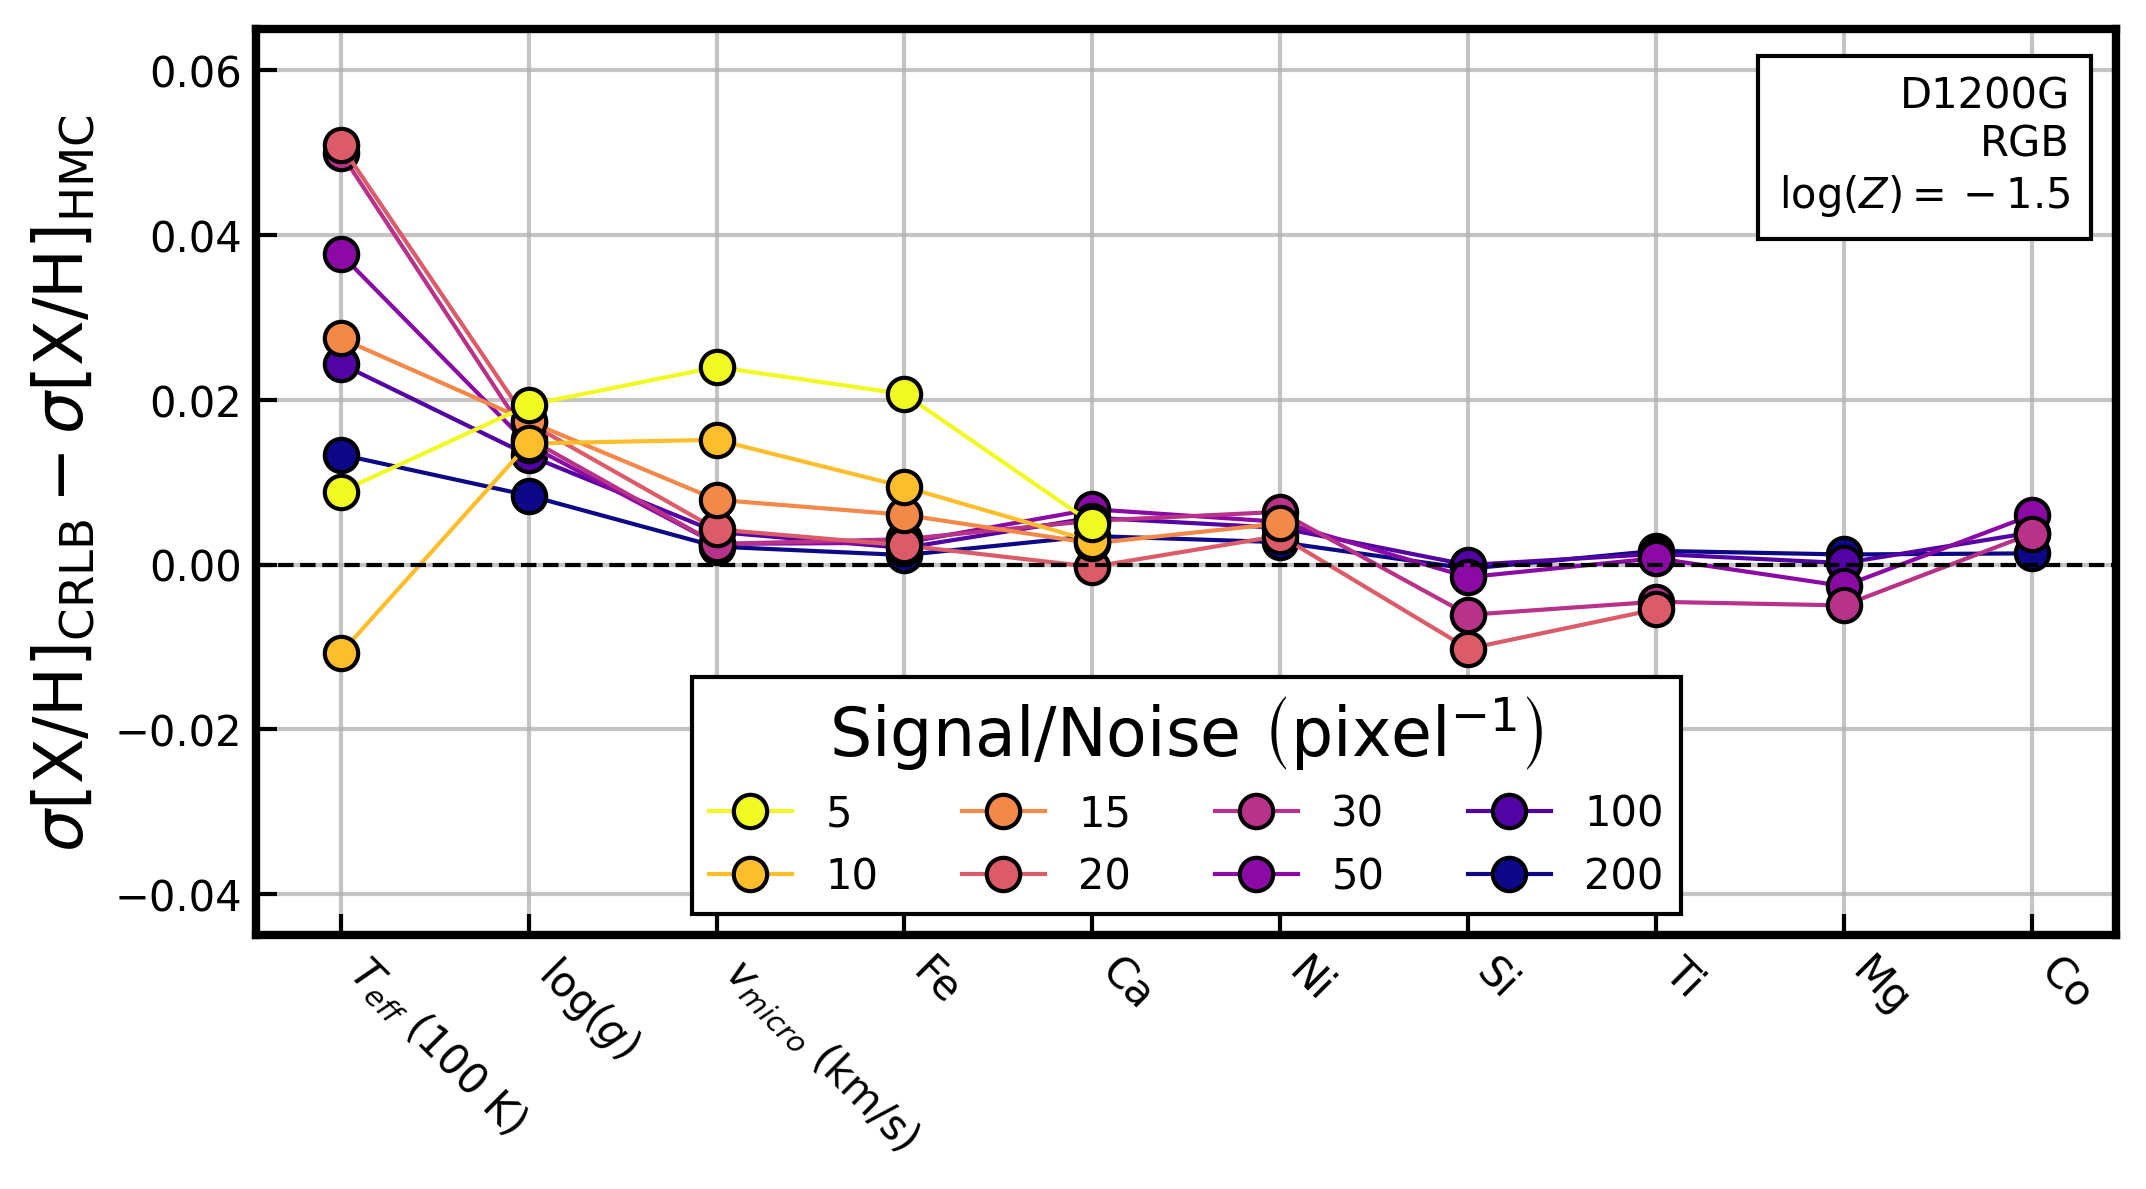

In [10]:
# Difference
crlb_diff = (CRLB_NN-CRLB_hmc).loc[CRLB_NN.index]

# Initialize Figure
fig = plt.figure(figsize=(8, 4))
gs = GridSpec(1, 1)
ax = plt.subplot(gs[0, 0])
c = plt.cm.get_cmap('plasma', len(crlb_diff.columns))
# Plot CRLB - HMC Std
for j, col in enumerate(crlb_diff):
    mask = np.isfinite(crlb_diff.loc[:,col].values)
    plt.plot(crlb_diff.loc[:, col].index[mask],
             crlb_diff.loc[:, col].values[mask],
             marker='o', markersize=8, markeredgewidth=1,
             linestyle='-', linewidth=1,
             color=c(j), markeredgecolor='k',
             label=col)
# Annotations
ax.axhline(0.0, ls='--', lw=1, c='k')
ax.text(0.975, 0.95, s='D1200G\nRGB\n$\log(Z)=-1.5$', fontsize=10,
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes,
        bbox=dict(facecolor='white', edgecolor='black', pad=5.0))
#Axes
ax.set_ylabel(r'$\sigma\mathrm{[X/H]}_\mathrm{CRLB}-\sigma\mathrm{[X/H]}_\mathrm{HMC}$', size=16)
ax.set_ylim(-0.045, 0.065)
ax.tick_params(axis='x', which='major', rotation=-45)
for label in ax.get_xticklabels():
    label.set_horizontalalignment('left')
# Legend
legend = plt.legend()
handles, labels = fig.axes[0].get_legend_handles_labels()
legend = fig.axes[0].legend(handles[::-1], labels[::-1], fontsize=10,
                            ncol=4, loc='lower center', edgecolor='k',
                            title=r'Signal/Noise $\left(\mathrm{pixel}^{-1}\right)$')
legend.get_title().set_fontsize('16')
fig.savefig(output_dir+'crlb_validation.png')

# Appendix F

## Figure 23: DESI CRLBs

In [11]:
# Initialize Preset Instrument
desi_b = inst.AllInst.get_spectrograph('DESI (b)')
desi_r = inst.AllInst.get_spectrograph('DESI (r)')
desi_i = inst.AllInst.get_spectrograph('DESI (i)')

# Initialize Reference Spectra
RGB_m15 = ref.ReferenceSpectra(reference='RGB_m1.5')
TRGB_m15 = ref.ReferenceSpectra(reference='TRGB_m1.5')
MSTO_m15 = ref.ReferenceSpectra(reference='MSTO_m1.5')

# Convolve Reference Spectra to Instrument Resolution
RGB_m15.convolve(desi_b)
RGB_m15.convolve(desi_r)
RGB_m15.convolve(desi_i)
TRGB_m15.convolve(desi_b)
TRGB_m15.convolve(desi_r)
TRGB_m15.convolve(desi_i)
MSTO_m15.convolve(desi_b)
MSTO_m15.convolve(desi_r)
MSTO_m15.convolve(desi_i)

# Calculate Gradient Spectra
RGB_m15.calc_gradient(desi_b)
RGB_m15.calc_gradient(desi_r)
RGB_m15.calc_gradient(desi_i)
TRGB_m15.calc_gradient(desi_b)
TRGB_m15.calc_gradient(desi_r)
TRGB_m15.calc_gradient(desi_i)
MSTO_m15.calc_gradient(desi_b)
MSTO_m15.calc_gradient(desi_r)
MSTO_m15.calc_gradient(desi_i)

# Initialize CRLB Data Frames
CRLB_desi = init_crlb_df(RGB_m15)

# Query S/N & Calculate CRLBs
desi_b.set_snr(30)
desi_r.set_snr(30)
desi_i.set_snr(30)
CRLB_desi['TRGB'] = calc_crlb(TRGB_m15, [desi_b, desi_r, desi_i])
CRLB_desi['RGB'] = calc_crlb(RGB_m15, [desi_b, desi_r, desi_i])
CRLB_desi['MSTO'] = calc_crlb(MSTO_m15, [desi_b, desi_r, desi_i])

# Sort CRLBs & Pretty Up Indices
CRLB_desi = sort_crlb(CRLB_desi, cutoff=0.3, fancy_labels=True)

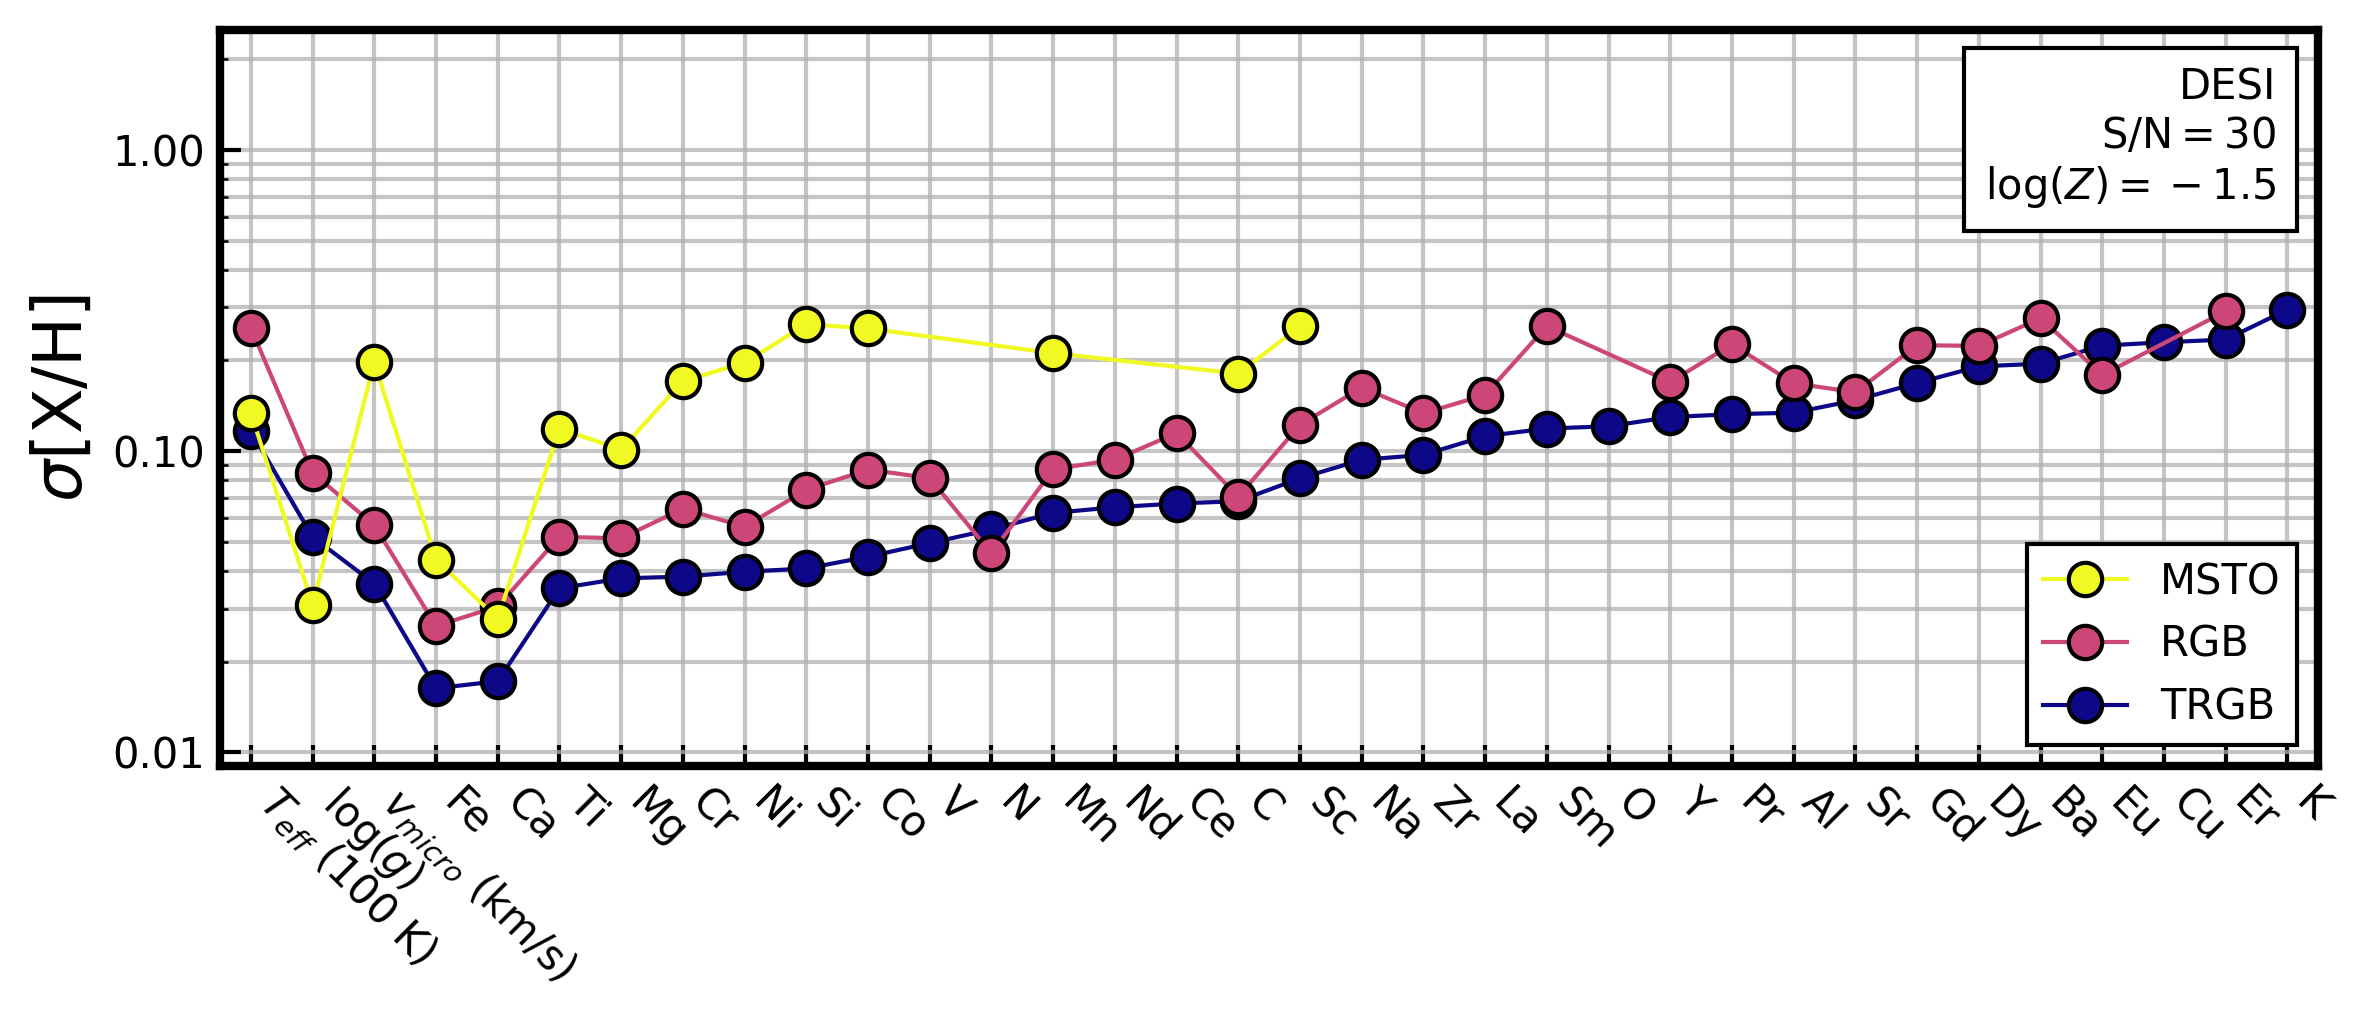

In [12]:
fig = plot_crlb([CRLB_desi],
                labels=['DESI\n$\mathrm{S/N}=30$\n$\log(Z)=-1.5$'],
                panel_height=3.5, cutoff_label_xoffset=4,
                ylim=(0.009, 2.5), legend_ncol=1, reverse_legend=True)
fig.savefig(output_dir+'crlb_desi.png')